**Importing Libraries And Modules**

In [24]:
from google.colab import files

In [25]:
import pandas as pd
import numpy as np
import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import minmax_scale
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import swiftxrt_clean

In [26]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


**Cleaning Of Raw SWIFT XRT Data**

In [29]:
swiftxrt_clean.clean_file('/content/GRB_130527A.dat')

In [30]:
data_orig = pd.read_table('/content/GRB_130527A.dat',sep='\s+')
data_orig

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
0,94.447602,0.467799,-0.432429,2.362496e-09,3.547334e-10,-7.779951
1,95.549019,0.544168,-0.633618,1.983100e-09,3.005101e-10,-6.569347
2,96.939846,0.978652,-0.846659,1.890324e-09,3.418797e-10,-7.172329
3,98.553637,0.482191,-0.635139,2.411023e-09,4.053081e-10,-9.454839
4,99.526375,0.576923,-0.490547,2.489416e-09,4.046685e-10,-9.374972
...,...,...,...,...,...,...
119,11015.317000,224.479000,-344.680000,1.830821e-12,4.804741e-13,-0.010583
120,11585.100000,431.957000,-345.303000,2.201158e-12,4.457495e-13,-0.009818
121,16782.543000,250.139000,-326.543000,1.562182e-12,4.113406e-13,-0.009060
122,17262.654000,311.607000,-229.972000,1.671471e-12,4.367429e-13,-0.009620


In [ ]:
from pandas import DataFrame as df

Y = df.to_numpy(data_orig)

In [ ]:
Y

array([[ 1.40293000e+02,  3.59000000e-01, -3.37000000e-01,
         2.27341289e-09,  3.46054125e-10, -1.07194200e+01],
       [ 1.41023000e+02,  3.74000000e-01, -3.72000000e-01,
         2.12146788e-09,  3.22918895e-10, -1.00023000e+01],
       [ 1.41714000e+02,  2.84000000e-01, -3.17000000e-01,
         2.62983370e-09,  4.00298422e-10, -1.23990100e+01],
       ...,
       [ 8.18623900e+04,  7.24590000e+02, -6.99553000e+02,
         8.24726882e-13,  1.57202227e-13, -4.86694200e-03],
       [ 8.64989550e+04,  4.37046000e+02, -7.01268000e+02,
         6.98150611e-13,  1.66601785e-13, -5.15795000e-03],
       [ 2.32156794e+05,  8.11878000e+02, -9.25685000e+02,
         3.43657465e-13,  1.02904473e-13, -2.66356800e-03]])

Text(0, 0.5, 'Flux (erg/cm^2/s)')

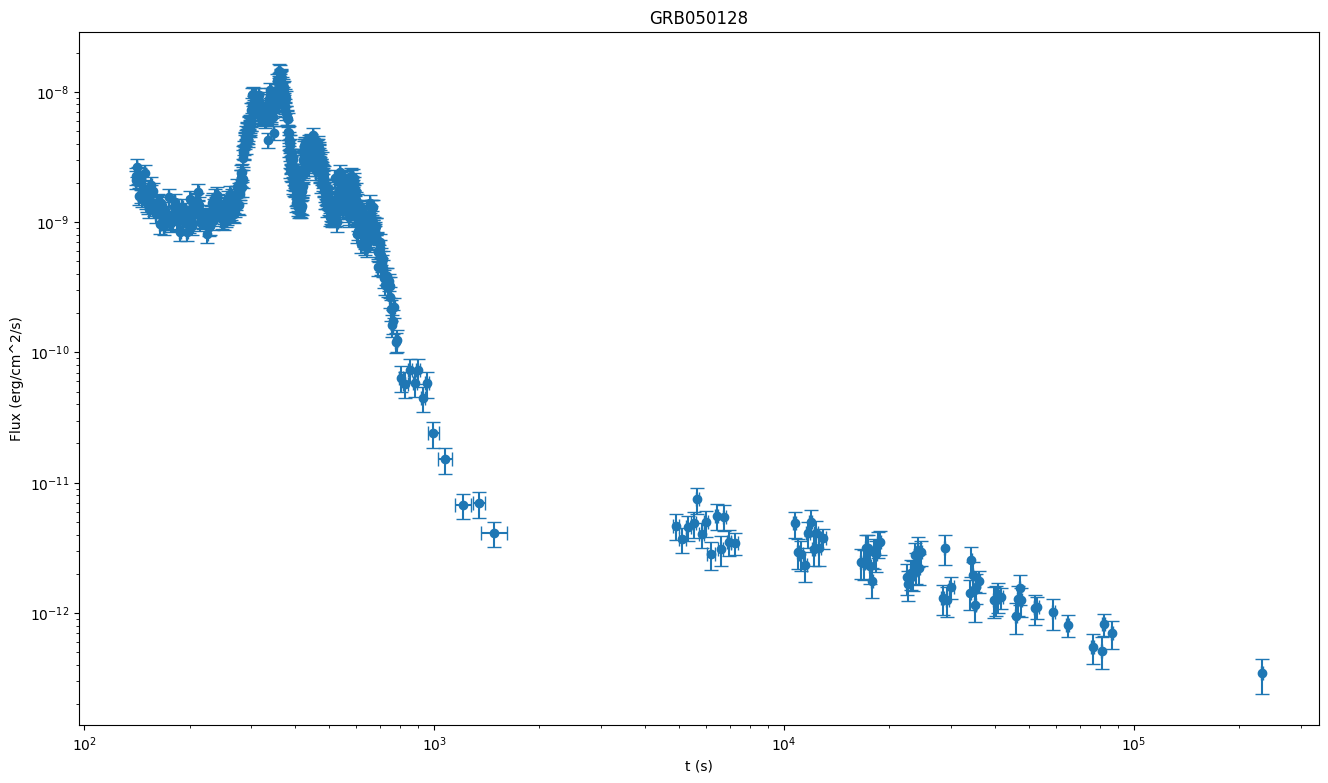

In [ ]:
plt.figure(figsize=(16,9))
plt.errorbar(Y[:,0], Y[:,3], linestyle='none', xerr=Y[:,1], yerr=Y[:,4], marker='o',capsize=5)
plt.loglog()
plt.title("GRB050128")
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")

In [ ]:
after_burst = data_orig


In [ ]:
after_burst = after_burst.sort_values(by=['!Time'])

In [ ]:
after_burst

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
0,140.293,0.359,-0.337,2.273413e-09,3.460541e-10,-10.719420
1,141.023,0.374,-0.372,2.121468e-09,3.229189e-10,-10.002300
2,141.714,0.284,-0.317,2.629834e-09,4.002984e-10,-12.399010
3,142.387,0.309,-0.388,2.302995e-09,3.433406e-10,-10.634540
4,143.204,0.490,-0.509,1.584483e-09,2.411727e-10,-7.469461
...,...,...,...,...,...,...
643,76167.312,635.437,-530.457,5.491675e-13,1.457026e-13,-0.004511
644,80798.463,364.373,-783.974,5.131585e-13,1.402471e-13,-0.004342
645,81862.390,724.590,-699.553,8.247269e-13,1.572022e-13,-0.004867
646,86498.955,437.046,-701.268,6.981506e-13,1.666018e-13,-0.005158


In [ ]:
def create_batches(N,Ba_Sz,updated_after_burst):
  batches = []
  start = 0
  while(start < N) :
    if start + Ba_Sz <= N :
      after_burst_even = updated_after_burst.iloc[start:start + Ba_Sz]
      after_burst_even = after_burst_even.reset_index()
      batches.append(upsample_data(after_burst_even))
    else :
      after_burst_even = updated_after_burst.iloc[start:N]
      after_burst_even = after_burst_even.reset_index()
      batches.append(upsample_data(after_burst_even))
    start = start + Ba_Sz
  return batches

In [ ]:
def create_data(t,f):
  updated_after_burst = pd.DataFrame()
  updated_after_burst[t] = []
  updated_after_burst[f] = []
  for i in range(after_burst.shape[0]-1) :
    start_time = after_burst[t][i]
    end_time = after_burst[t][i+1]
    start_flux = after_burst[f][i]
    end_flux = after_burst[f][i+1]
    time_upd = (end_time - start_time) / 20
    flux_upd = (end_flux - start_flux) / 20
    for j in range(19):
      new_row = {t : start_time, f : start_flux}
      updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
      start_time = start_time + time_upd
      start_flux = start_flux + flux_upd
  return updated_after_burst


In [ ]:
def upsample_data(data):
  while(data.shape[0] < 20000) :
    data = data.append(data,ignore_index = True)
  return data

In [ ]:
def create_sequence(dataset):
    data_sequences = []
    for index in range(len(dataset)):
        data_sequences.append(dataset[index:index+1])
    return np.asarray(data_sequences)

In [ ]:
# Creating RNN Model Via Function Definition

def create_bilstm(units,X,Y):
    model = Sequential()

    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(X.shape[0], X.shape[1])
              ))

    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units,return_sequences=True)))
    model.add(Bidirectional(LSTM(units = units)))
    layer = tf.keras.layers.Dense(1,activation = 'relu')
    model.add(layer)
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model


In [ ]:
units = 100

In [ ]:
# Training Of Model Via Function Definition

def fit_model(model,X,Y):
    early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 5)
    history = model.fit(X, Y, epochs = 75,
                        validation_split = 0.4,
                        batch_size =15, shuffle = True,
                        callbacks = [early_stop]
                        )
    return history

In [ ]:
def train_model(batches,B,t,f):
  # Training And Predicting For Each Batch

  preds = []

  for b in range(B) :
    batch = batches[b]
    X = batch[t]
    Y = batch[f]
    X = create_sequence(X)
    Y = Y[-X.shape[0]:]
    print('Model Training / Batch Number : {}'.format(b+1))
    model_b = create_bilstm(units,X,Y)
    histor = fit_model(model_b,X,Y)
    pr = model_b.predict(X)
    for x in pr :
      preds.append(x)
  return preds

In [ ]:
def time_seq(batches,B,t):
  time_predict = []
  for b in range(B) :
    for i in range(len(batches[b])):
      val = (batches[b][t][i])
      time_predict.append(val)
  return time_predict

**DATA PREPROCESSING**

In [ ]:
after_burst['!Time'] = (after_burst['!Time']) / 10**2

In [ ]:
b = after_burst['Flux'].min()
b

3.43657465e-13

In [ ]:
after_burst['Flux'] = np.log(after_burst['Flux'] / b) + 1

In [ ]:
a = after_burst['Fluxpos'].min()

In [ ]:
after_burst['Fluxpos'] = np.log(after_burst['Fluxpos'] / a) + 1

**FLUX TIME PREDICTION**

In [ ]:
flux_time_upd_data = create_data('!Time','Flux')

Streaming output truncated to the last 5000 lines.
<ipython-input-143-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-143-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-143-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updated_after_burst.append(new_row,ignore_index = True)
<ipython-input-143-a01cad969440>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_after_burst = updat

In [ ]:
# Input for Number Of Data Points In Each Batch

Ba_Sz = int(input())

9000


In [ ]:
N = flux_time_upd_data.shape[0]

In [ ]:
batches_flux_time = create_batches(N,Ba_Sz,flux_time_upd_data)

<ipython-input-144-e353ce9f2ad7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data,ignore_index = True)
<ipython-input-144-e353ce9f2ad7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data,ignore_index = True)


In [ ]:
B = len(batches_flux_time)

In [ ]:
with tf.device(device_name):
  flux_preds = train_model(batches_flux_time,B,'!Time','Flux')

Model Training / Batch Number : 1
Epoch 1/75
1440/1440 [==============================] - 43s 20ms/step - loss: 1.8204 - val_loss: 0.5089
Epoch 2/75
1440/1440 [==============================] - 26s 18ms/step - loss: 0.3725 - val_loss: 0.2669
Epoch 3/75
1440/1440 [==============================] - 25s 18ms/step - loss: 0.1638 - val_loss: 0.1595
Epoch 4/75
1440/1440 [==============================] - 25s 18ms/step - loss: 0.0901 - val_loss: 0.0830
Epoch 5/75
1440/1440 [==============================] - 25s 18ms/step - loss: 0.0527 - val_loss: 0.0320
Epoch 6/75
1440/1440 [==============================] - 26s 18ms/step - loss: 0.0366 - val_loss: 0.0318
Epoch 7/75
1440/1440 [==============================] - 26s 18ms/step - loss: 0.0302 - val_loss: 0.0260
Epoch 8/75
1440/1440 [==============================] - 25s 18ms/step - loss: 0.0307 - val_loss: 0.0436
Epoch 9/75
1440/1440 [==============================] - 26s 18ms/step - loss: 0.0253 - val_loss: 0.0420
Epoch 10/75
1440/1440 [=======

**Re Organising and Plotting of Data**

In [ ]:
batches_flux_time

[       index     !Time      Flux
 0          0  1.402930  9.797147
 1          1  1.403295  9.793689
 2          2  1.403660  9.790230
 3          3  1.404025  9.786771
 4          4  1.404390  9.783313
 ...      ...       ...       ...
 35995   8995  5.823012  9.479965
 35996   8996  5.823429  9.487218
 35997   8997  5.823845  9.494471
 35998   8998  5.824262  9.501725
 35999   8999  5.824678  9.508978
 
 [36000 rows x 3 columns],
        index        !Time      Flux
 0       9000     5.825095  9.516232
 1       9001     5.825511  9.523485
 2       9002     5.825928  9.530738
 3       9003     5.826344  9.537992
 4       9004     5.826761  9.545245
 ...      ...          ...       ...
 26339  12288  1884.594423  1.212637
 26340  12289  1957.423342  1.177197
 26341  12290  2030.252262  1.141758
 26342  12291  2103.081181  1.106318
 26343  12292  2175.910101  1.070879
 
 [26344 rows x 3 columns]]

In [ ]:
fl = []
ti = []
for batch in batches_flux_time :
  for f in batch['Flux']:
    fl.append(f)
  for t in batch['!Time']:
    ti.append(t)

In [ ]:
Flux_std = np.std(fl)
Time_std = np.std(ti)

In [ ]:
Flux_std

2.690908966414041

In [ ]:
Time_std

144.6476942661327

In [ ]:
time_predict = time_seq(batches_flux_time,len(batches_flux_time),'!Time')

In [ ]:
time_predict = np.array(time_predict)
X_new , idx = np.unique(time_predict,return_index = True)
Y_new = [flux_preds[i] for i in idx]

In [ ]:
X_new.shape


(12293,)

In [ ]:
Y_new = np.array(Y_new)

In [ ]:
Y_new.shape

(12293, 1)

Text(0.5, 1.0, 'Flux vs Time Prediction for Break Bump (with double break) GRB 070129')

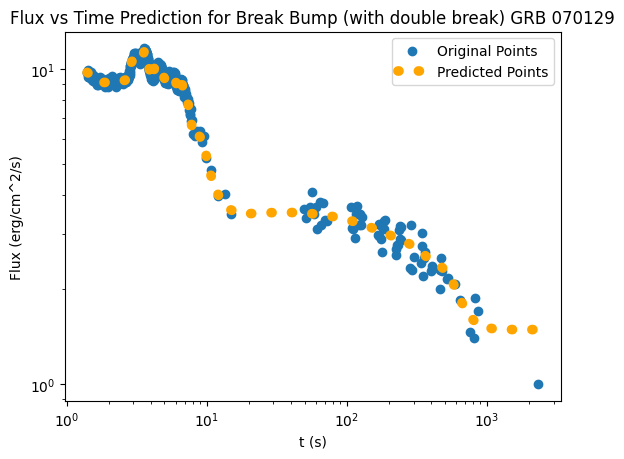

In [ ]:
plt.scatter(after_burst['!Time'],after_burst['Flux'])
plt.plot(X_new,Y_new[:,0],color='orange',  linestyle = (0,(0.1,2)),
    dash_capstyle = 'round', linewidth=7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("t (s)")
plt.ylabel("Flux (erg/cm^2/s)")
plt.legend(['Original Points','Predicted Points'])
plt.title("Flux vs Time Prediction for Break Bump (with double break) GRB 070129")

In [ ]:
Y_new_std = np.std(Y_new)
Y_new_std

2.705557

In [ ]:
X = pd.DataFrame()
X['!Time'] = X_new

X['Flux'] = Y_new

In [ ]:
Y_new[4250:]

array([], shape=(0, 1), dtype=float32)

In [ ]:
X = df.to_numpy(X)

In [ ]:
Y_temp = Y

In [ ]:
Y_temp

array([[ 1.25025000e+02,  1.64670000e+01, -2.86640000e+01,
         1.12474958e-10,  2.53451957e-11, -7.54321300e-01],
       [ 1.60327000e+02,  2.12830000e+01, -1.88340000e+01,
         1.31357083e-10,  2.88228864e-11, -8.57824000e-01],
       [ 2.01584000e+02,  1.76350000e+01, -1.99740000e+01,
         1.33331386e-10,  2.98712736e-11, -8.89026000e-01],
       [ 2.61564000e+02,  2.53520000e+01, -4.23450000e+01,
         9.21598608e-11,  1.85365723e-11, -5.51683700e-01],
       [ 2.96359000e+02,  5.60100000e+00, -9.44200000e+00,
         7.21274400e-10,  1.10388432e-10, -3.28537000e+00],
       [ 3.07672000e+02,  4.31800000e+00, -5.71200000e+00,
         9.29890416e-10,  1.53298118e-10, -4.56244400e+00],
       [ 3.15517000e+02,  3.99500000e+00, -3.52700000e+00,
         1.10340955e-09,  1.92602928e-10, -5.73223000e+00],
       [ 3.24179000e+02,  5.36100000e+00, -4.66800000e+00,
         7.58196432e-10,  1.38664210e-10, -4.12691100e+00],
       [ 3.34220000e+02,  7.85700000e+00, -4.680

In [ ]:
Y_temp[:,0] = Y_temp[:,0] / 100

In [ ]:
Y_temp[:,3] = np.log(Y_temp[:,3] / np.min(Y_temp[:,3])) + 1
Y_temp[:,4] = np.log(Y_temp[:,4] / np.min(Y_temp[:,4])) + 1

In [ ]:
Y_temp

array([[ 1.25025000e+00,  1.64670000e+01, -2.86640000e+01,
         7.30124290e+00,  6.90750019e+00, -7.54321300e-01],
       [ 1.60327000e+00,  2.12830000e+01, -1.88340000e+01,
         7.45643173e+00,  7.03608073e+00, -8.57824000e-01],
       [ 2.01584000e+00,  1.76350000e+01, -1.99740000e+01,
         7.47134994e+00,  7.07180827e+00, -8.89026000e-01],
       [ 2.61564000e+00,  2.53520000e+01, -4.23450000e+01,
         7.10203698e+00,  6.59465666e+00, -5.51683700e-01],
       [ 2.96359000e+00,  5.60100000e+00, -9.44200000e+00,
         9.15953194e+00,  8.37891634e+00, -3.28537000e+00],
       [ 3.07672000e+00,  4.31800000e+00, -5.71200000e+00,
         9.41357904e+00,  8.70729551e+00, -4.56244400e+00],
       [ 3.15517000e+00,  3.99500000e+00, -3.52700000e+00,
         9.58467255e+00,  8.93554170e+00, -5.73223000e+00],
       [ 3.24179000e+00,  5.36100000e+00, -4.66800000e+00,
         9.20945479e+00,  8.60696625e+00, -4.12691100e+00],
       [ 3.34220000e+00,  7.85700000e+00, -4.680

In [ ]:
type(Y_temp)

numpy.ndarray

In [ ]:
Y_df = pd.DataFrame(Y_temp)
Y_df

,0,1,2,3,4,5
0,1.25025,16.467,-28.664,7.301243,6.907500,-0.754321
1,1.60327,21.283,-18.834,7.456432,7.036081,-0.857824
2,2.01584,17.635,-19.974,7.471350,7.071808,-0.889026
3,2.61564,25.352,-42.345,7.102037,6.594657,-0.551684
4,2.96359,5.601,-9.442,9.159532,8.378916,-3.285370
5,3.07672,4.318,-5.712,9.413579,8.707296,-4.562444
6,3.15517,3.995,-3.527,9.584673,8.935542,-5.732230
7,3.24179,5.361,-4.668,9.209455,8.606966,-4.126911
8,3.34220,7.857,-4.680,9.049384,8.417333,-3.414038
9,3.49807,7.314,-7.730,8.869594,8.235532,-2.846513


In [ ]:
data_orig

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
0,159.277,48.513,-61.808,8.181223e-11,1.844838e-11,-0.243382
1,257.965,60.146,-50.175,8.188735e-11,1.840698e-11,-0.242836
2,426.018,198.161,-107.906,4.608117e-11,1.025002e-11,-0.135224
3,4224.405,138.014,-192.950,4.579111e-12,1.195571e-12,-0.015773
4,4647.101,327.100,-284.682,2.422372e-12,6.392286e-13,-0.008433
5,5177.305,165.469,-203.104,3.995031e-12,1.048950e-12,-0.013838
6,5555.769,193.188,-212.996,3.632774e-12,9.562291e-13,-0.012615
7,6045.426,473.680,-296.469,4.411743e-12,8.497165e-13,-0.011210
8,10810.049,1430.988,-1052.383,1.039859e-12,2.294621e-13,-0.003027
9,22458.811,1389.898,-1125.088,7.614110e-13,2.840343e-13,-0.003029


In [ ]:
error_calculation_x = data_orig.loc[1:,:]

In [ ]:
error_calculation_x

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
1,257.965,60.146,-50.175,8.188735e-11,1.840698e-11,-0.242836
2,426.018,198.161,-107.906,4.608117e-11,1.025002e-11,-0.135224
3,4224.405,138.014,-192.950,4.579111e-12,1.195571e-12,-0.015773
4,4647.101,327.100,-284.682,2.422372e-12,6.392286e-13,-0.008433
5,5177.305,165.469,-203.104,3.995031e-12,1.048950e-12,-0.013838
6,5555.769,193.188,-212.996,3.632774e-12,9.562291e-13,-0.012615
7,6045.426,473.680,-296.469,4.411743e-12,8.497165e-13,-0.011210
8,10810.049,1430.988,-1052.383,1.039859e-12,2.294621e-13,-0.003027
9,22458.811,1389.898,-1125.088,7.614110e-13,2.840343e-13,-0.003029


In [ ]:
error_calculation_x['Flux'][1]

8.18873464e-11

In [ ]:
error_calculation_x['!Time'] = error_calculation_x['!Time'] / 100

<ipython-input-80-8e5b829fa29e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_calculation_x['!Time'] = error_calculation_x['!Time'] / 100


In [ ]:
error_calculation_x

,!Time,T_+ve,T_-ve,Flux,Fluxpos,Fluxneg
1,257.965,60.146,-50.175,8.188735e-11,1.840698e-11,-0.242836
2,426.018,198.161,-107.906,4.608117e-11,1.025002e-11,-0.135224
3,4224.405,138.014,-192.950,4.579111e-12,1.195571e-12,-0.015773
4,4647.101,327.100,-284.682,2.422372e-12,6.392286e-13,-0.008433
5,5177.305,165.469,-203.104,3.995031e-12,1.048950e-12,-0.013838
6,5555.769,193.188,-212.996,3.632774e-12,9.562291e-13,-0.012615
7,6045.426,473.680,-296.469,4.411743e-12,8.497165e-13,-0.011210
8,10810.049,1430.988,-1052.383,1.039859e-12,2.294621e-13,-0.003027
9,22458.811,1389.898,-1125.088,7.614110e-13,2.840343e-13,-0.003029


In [ ]:
flux_predict = batches_flux_time[0]['!Time']
flux_predict[19]

2.5796499999999996

In [ ]:
import math
idx = -1
j = 1
bania =  257.968
err_bania = 10000.00
for i in flux_predict:
  if abs(bania-i) < err_bania:
    idx = j
    err_bania = abs(bania-i)
  j += 1
print(idx)




20


In [ ]:
print(flux_predict[573][])

In [ ]:
y_init = [flux_predict[i] for i in idx]
y_init[0]

7.301242898123436

In [ ]:
Y_new

array([[5.6626062],
       [5.6633277],
       [5.66384  ],
       [5.6641974],
       [5.6644373],
       [5.6645823],
       [5.6646504],
       [5.6646543],
       [5.6646037],
       [5.6645093],
       [5.6643806],
       [5.6642303],
       [5.6640744],
       [5.663932 ],
       [5.663825 ],
       [5.663773 ],
       [5.663776 ],
       [5.663796 ],
       [5.663708 ],
       [5.6618404],
       [5.654513 ],
       [5.6349344],
       [5.602862 ],
       [5.569458 ],
       [5.5392985],
       [5.510736 ],
       [5.4822745],
       [5.4533052],
       [5.4236774],
       [5.393427 ],
       [5.3626833],
       [5.33164  ],
       [5.3005633],
       [5.2698007],
       [5.2397633],
       [5.210905 ],
       [5.1836677],
       [5.1584244],
       [5.114808 ],
       [4.955747 ],
       [4.843948 ],
       [4.7028623],
       [4.576471 ],
       [4.4595537],
       [4.345228 ],
       [4.231294 ],
       [4.1175327],
       [4.0046244],
       [3.8929336],
       [3.7816198],


In [ ]:
print(Y_new)